# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from art.utils import load_mnist
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import TargetedUniversalPerturbation

# Load Data

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

# Model

In [3]:
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10)
])

In [4]:
model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer=Adam(), metrics=["accuracy"])

# Train

In [5]:
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2464 - accuracy: 0.9256
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1151 - accuracy: 0.9646
Epoch 3/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0824 - accuracy: 0.9739
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0694 - accuracy: 0.9776
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0550 - accuracy: 0.9822
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0479 - accuracy: 0.9847
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0417 - accuracy: 0.9866
Epoch 8/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0344 - accuracy: 0.9891
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0338 - accuracy: 0.9891
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.029

# Attack

In [6]:
art_model = TensorFlowV2Classifier(
    model=model, 
    loss_object=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(),
    nb_classes=10, 
    input_shape=(28, 28), 
    clip_values=(0, 1)
)

In [54]:
labels1 = [5]
indices_5 = [idx for idx, target in enumerate(y_test) if np.argmax(target, axis=0) in labels1]

In [55]:
labels2 = [6]
indices_6 = [idx for idx, target in enumerate(y_test) if np.argmax(target, axis=0) in labels2]

In [56]:
x_test_5, y_test_5 = x_test[indices_5], y_test[indices_6]

In [59]:
y_test_5 = y_test[:len(x_test_5)]

In [60]:
len(x_test_5), len(y_test_5)

(892, 892)

In [61]:
attack = TargetedUniversalPerturbation(classifier=art_model, attacker="fgsm", delta=0, max_iter=5)

In [62]:
adv_test = attack.generate(x=x_test_5, y=y_test_5)

# Results

In [63]:
y_test_5 = np.argmax(y_test_5, axis=1)

In [67]:
adv_preds = np.argmax(art_model.predict(adv_test), axis=1)

In [68]:
adv_model_scores = {
    'ACC': accuracy_score(y_test_5, adv_preds),
    'PREC': precision_score(y_test_5, adv_preds, average='weighted'),
    'REC': recall_score(y_test_5, adv_preds, average='weighted'),
    'F1': f1_score(y_test_5, adv_preds, average='weighted')
}

/home/alper/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [69]:
adv_model_scores

{'ACC': 0.09080717488789238,
 'PREC': 0.054444455846185943,
 'REC': 0.09080717488789238,
 'F1': 0.019119367590790724}

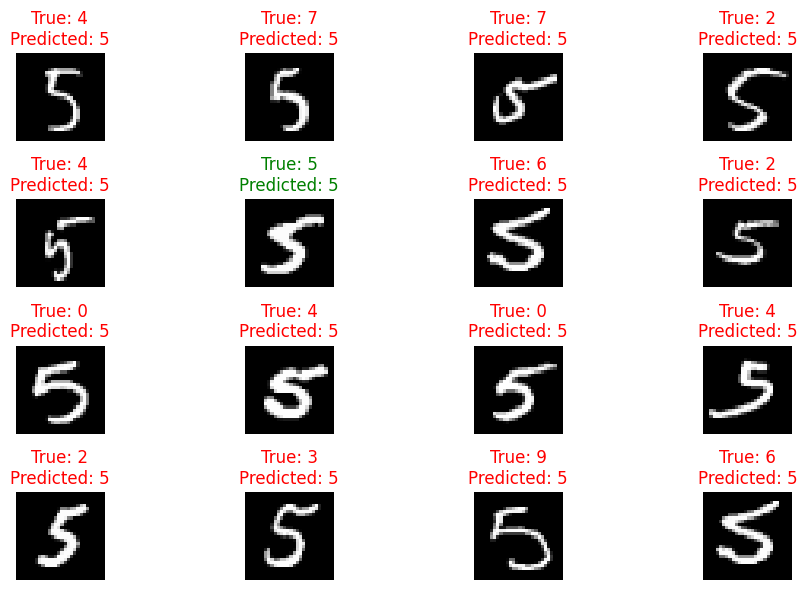

In [70]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 6))
random_index = np.random.randint(0, len(adv_test), 16)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(adv_test[random_index[i]].reshape(28, 28), cmap='gray')
    ax.axis('off')

    if y_test_5[random_index[i]] == adv_preds[random_index[i]]:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(
        f'True: {y_test_5[random_index[i]]}\nPredicted: {adv_preds[random_index[i]]}',
        color=color
    )

plt.tight_layout()
plt.show()